In [1]:
# library import
import os
import re
import pdfplumber
import numpy as np
import pandas as pd 
import json
import tabula  #for table processing
from itertools import islice # iterates through directions


os.chdir(r'C:\Users\Owner\OneDrive\Research_Git\DS_Misc\Credit_DealDoc_Proc')
import scrape

In [2]:
# Enable multiple output per cell. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

os.chdir(r'C:\Users\Owner\OneDrive\Digital Mosaic\Product\Solutions\Vibrant\Deal_Docs')

### Dataframe: Definition Name & Definition Value
Note pdfplumber treats page 1 as page 0. Hence a start_page of 5 means pdfplumber pulls from page 6. 

In [3]:
file_name_oh = 'OHA XII Indenture.pdf'
start_page_oh = 8
end_page_oh = 85

In [4]:
# extract pages from both documents. 
oh_pages = scrape.pdf_extract_pages(file_name_oh, start_page_oh, end_page_oh)
doc_str_oh = scrape.combine_strings(oh_pages) 

In [5]:
# Isoalte locations for defintions and strings for each 
regex_oh = r'“.*”:'
def_locs_oh = scrape.text_match_2list(regex_oh, doc_str_oh)
def_descr_oh = scrape.list_betweenloc_to_string_bounded(def_locs_oh, doc_str_oh, len(doc_str_oh))

In [6]:
df_defs = pd.DataFrame([doc_str_oh[x[0]+1:x[1]-2] for x in def_locs_oh])
df_defs['description'] = def_descr_oh
df_defs.columns = ['def_name','def_description']
df_defs.head() 

,def_name,def_description
0,Acceleration Event,The meaning specified in the Acceleration Pr...
1,Acceleration Priority of Payments,The meaning specified in \nSection 11.1...
2,Account Agreement,An agreement in substantially the form of Ex...
3,Accountants’ Effective Date Comparison AUP Report,A report of agreed \nupon procedures perform...
4,Accountants’ Effective Date Recalculation AUP ...,A report of agreed \nupon procedures perfor...


### Add page numbers
1. Loop ```oh_pages``` to grab page numbers and add them back into dictionary. 
2. Merge back into ```df_defs```

In [7]:
regex_oh = r'“.*”:'
def_names = []
for i,page in enumerate(oh_pages):
    page_num = i + 9
    ranges = scrape.text_match_2list(regex_oh, page)
    for range in ranges:
        def_names.append([page[range[0]+1:range[1]-2], page_num])

In [8]:
def_name_pages = pd.DataFrame(def_names, columns=['def_name','page_num'])
df_defs = pd.merge(df_defs, def_name_pages, on='def_name', how='left')
df_defs.head() 

,def_name,def_description,page_num
0,Acceleration Event,The meaning specified in the Acceleration Pr...,9
1,Acceleration Priority of Payments,The meaning specified in \nSection 11.1...,9
2,Account Agreement,An agreement in substantially the form of Ex...,9
3,Accountants’ Effective Date Comparison AUP Report,A report of agreed \nupon procedures perform...,10
4,Accountants’ Effective Date Recalculation AUP ...,A report of agreed \nupon procedures perfor...,10


### Bullet Point Detection
1. Create columns with location of first bullet for different types of bullets such as (a), (i), (A), (I), etc. 
2. create regex lists for each type to allow search in order 

In [9]:
# Detect Roman numerals 
regex = r"[\n\s]\(i\)"
match_reg = [re.search(regex, x) for x in df_defs['def_description']]
roman_bullet_flag = [x.span()[0] if x is not None else 0 for x in match_reg]
df_defs['roman_bullets_loc'] = roman_bullet_flag
df_defs.iloc[10:16]   

,def_name,def_description,page_num,roman_bullets_loc
10,Additional Notes Closing Date,The closing date for the issuance of...,10,0
11,Adjusted Collateral Principal Amount,As of any date of determination: \n(a) the ...,10,526
12,Adjusted Coupon,As of any date of determination and with res...,11,0
13,Adjusted Spread,As of any date of determination and with res...,11,0
14,Administration Agreement,An agreement between the Administrator and t...,11,0
15,Administrative Expense Cap,An amount equal on any Payment Date (when \n...,11,419


In [10]:
# Detect Letter bullets: look for '(a)'
regex = r"[\n\s]\(a\)"
match_reg = [re.search(regex, x) for x in df_defs['def_description']]
letter_bullet_flag = [x.span()[0] if x is not None else 0 for x in match_reg]
df_defs['letter_bullets_loc'] = letter_bullet_flag
df_defs.iloc[6:12]   

,def_name,def_description,page_num,roman_bullets_loc,letter_bullets_loc
6,Accounts,(i) The Payment Account; (ii) the Coll...,10,3,0
7,Accredited Investor,An accredited investor as defined in Regulat...,10,0,0
8,Act” and “Act of Holders,The meanings specified in Section 14.2 (Acts...,10,0,0
9,Additional Notes,Any Notes issued pursuant to Section 2.4(a) ...,10,0,0
10,Additional Notes Closing Date,The closing date for the issuance of...,10,0,0
11,Adjusted Collateral Principal Amount,As of any date of determination: \n(a) the ...,10,526,35


In [11]:
df_defs_sub1 =df_defs[(
                        (df_defs.roman_bullets_loc < df_defs.letter_bullets_loc) & 
                         (df_defs.roman_bullets_loc != 0)
                        ) | 
                     ( 
                        (df_defs.roman_bullets_loc !=0) & 
                          (df_defs.letter_bullets_loc == 0)
                         )
                    ]
df_defs_sub1.iloc[2]

def_name                                        Administrative Expenses
def_description         Fees, expenses (including indemnities) and o...
page_num                                                             12
roman_bullets_loc                                                   452
letter_bullets_loc                                                    0
Name: 16, dtype: object

### Create regex lists for roman numerals. 
1. Explore Administrative Expenses definitions: shows (x) before, but not in middle. 
2. Look at Affiliates. shows (x) between roman numerals. 

In [12]:
roman_regex_list = [r"[\n\s]\(i\)", r"[\n\s]\(ii\)", r"[\n\s]\(iii\)", r"[\n\s]\(iv\)",
                     r"[\n\s]\(v\)", r"[\n\s]\(vi\)", r"[\n\s]\(vii\)", r"[\n\s]\(viii\)", 
                    r"[\n\s]\(ix\)", r"[\n\s]\(x\)", r"[\n\s]\(xi\)", r"[\n\s]\(xii\)", 
                    r"[\n\s]\(xiii\)", r"[\n\s]\(xiv\)", r"[\n\s]\(xv\)", r"[\n\s]\(xvi\)", 
                    r"[\n\s]\(xvii\)", r"[\n\s]\(xviii\)", r"[\n\s]\(xix\)", r"[\n\s]\(xx\)", 
                    r"[\n\s]\(xxi\)", r"[\n\s]\(xxii\)", r"[\n\s]\(xxiii\)", r"[\n\s]\(xxiv\)",
                    r"[\n\s]\(xxv\)", r"[\n\s]\(xxvi\)", r"[\n\s]\(xxvii\)", r"[\n\s]\(xxviii\)",
                    r"[\n\s]\(xxix\)", r"[\n\s]\(xxx\)"
                   ]

roman_upper_regex_list =  [r"[\n\s]\(I\)", r"[\n\s]\(II\)", r"[\n\s]\(III\)", r"[\n\s]\(IV\)",
                     r"[\n\s]\(V\)", r"[\n\s]\(VI\)", r"[\n\s]\(VII\)", r"[\n\s]\(VIII\)", 
                    r"[\n\s]\(IX\)", r"[\n\s]\(X\)", r"[\n\s]\(XI\)", r"[\n\s]\(XII\)", 
                    r"[\n\s]\(XIII\)", r"[\n\s]\(XIV\)", r"[\n\s]\(XV\)", r"[\n\s]\(XVI\)", 
                    r"[\n\s]\(XVII\)", r"[\n\s]\(XVIII\)", r"[\n\s]\(XIX\)", r"[\n\s]\(XX\)", 
                    r"[\n\s]\(XXI\)", r"[\n\s]\(XXII\)", r"[\n\s]\(XXIII\)",r"[\n\s]\(XXIV\)",
                    r"[\n\s]\(XXV\)", r"[\n\s]\(XXVI\)", r"[\n\s]\(XXVII\)", r"[\n\s]\(XXVIII\)",
                    r"[\n\s]\(XXIX\)", r"[\n\s]\(XXX\)"
                   ]

Admin Expenses: line 2 of definition (roman numerals first) subset <br> <br> 
Affiliates: line 18 of definitions set

Apply logic to all rows in <font color = aqua> Roman Numerals First </font> sub-table, then add to back to subtable. 

In [13]:
# show example for random definition with roman numeral
x_f = 0
df_defs_sub1['def_name'].iloc[x_f]
scrape.list_btn_loc_regexlist_keepbullet2_order(df_defs_sub1['def_description'].iloc[x_f], len(df_defs_sub1['def_description'].iloc[x_f]), roman_regex_list)

'Accounts'

[' (i) The  Payment  Account;',
 ' (ii) the  Collection  Account;',
 ' (iii) the \nRamp-Up Account',
 ' (iv) the Revolver Funding Account',
 ' (v) each Hedge Account (to the extent \npermitted under the related Hedge Agreement)',
 ' (vi) the Expense Reserve Account',
 ' (vii) the \nCustodial Account',
 ' (viii) the Ongoing Expense Maintenance Account',
 ' (ix) the Supplemental \nReserve Account',
 ' (x) the Contribution Account; an',
 ' (xi) the Tax Reserve Account. ']

In [14]:
rom_def_strings = [scrape.list_btn_loc_regexlist_keepbullet2_order(x,len(x),roman_regex_list) for x in df_defs_sub1['def_description']]
df_defs_sub1['roman_bullets'] = rom_def_strings 
df_defs_sub1.head() 

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,def_name,def_description,page_num,roman_bullets_loc,letter_bullets_loc,roman_bullets
6,Accounts,(i) The Payment Account; (ii) the Coll...,10,3,0,"[ (i) The Payment Account;, (ii) the Colle..."
15,Administrative Expense Cap,An amount equal on any Payment Date (when \n...,11,419,497,[ (i) upon the occurrence and continuation of ...
16,Administrative Expenses,"Fees, expenses (including indemnities) and o...",12,452,0,"[ (i) the Independent accountants, agents ..."
32,Balance,"On any date, with respect to Cash or Eligibl...",16,112,0,"[ (i) current balance of Cash, demand deposits..."
38,Business Day,Any day other than (i) a Saturday or a Sunda...,17,20,0,"[ (i) a Saturday or a Sunday o, (ii) a day on..."


### Process <font color=cyan> Letter </font> Bullet Points showing up first 

In [15]:
df_defs_sub2 =df_defs[(
                        (df_defs.roman_bullets_loc > df_defs.letter_bullets_loc) & 
                         (df_defs.letter_bullets_loc != 0)
                        ) | 
                     ( 
                        (df_defs.letter_bullets_loc !=0) & 
                          (df_defs.roman_bullets_loc == 0)
                         )
                    ]
df_defs_sub2.head()
len(df_defs_sub2) 

,def_name,def_description,page_num,roman_bullets_loc,letter_bullets_loc
11,Adjusted Collateral Principal Amount,As of any date of determination: \n(a) the ...,10,526,35
18,Affiliate” or “Affiliated,"With respect to a Person, (a) any other Pers...",13,240,27
20,Aggregate Excess Spread,"As of any date of determination, an amount e...",13,269,71
35,Benefit Plan Investor,(a) an employee benefit plan (as defined in ...,16,0,1
72,Clean-up Call Redemption Price,An amount at least equal to the sum of (a) t...,20,0,40


56

**Regex List for Letter Bullets** 

In [16]:
loweralpha_regex_list = [r"[\n\s]\(a\)", r"[\n\s]\(b\)", r"[\n\s]\(c\)", r"[\n\s]\(d\)",
                     r"[\n\s]\(e\)", r"[\n\s]\(f\)", r"[\n\s]\(g\)", r"[\n\s]\(h\)", 
                    r"[\n\s]\(i\)", r"[\n\s]\(j\)", r"[\n\s]\(k\)", r"[\n\s]\(l\)", 
                    r"[\n\s]\(m\)", r"[\n\s]\(n\)", r"[\n\s]\(o\)", r"[\n\s]\(p\)", 
                    r"[\n\s]\(q\)", r"[\n\s]\(r\)", r"[\n\s]\(s\)", r"[\n\s]\(t\)",
                    r"[\n\s]\(u\)", r"[\n\s]\(v\)", r"[\n\s]\(w\)", r"[\n\s]\(x\)",
                    r"[\n\s]\(y\)", r"[\n\s]\(z\)", r"[\n\s]\(aa\)", r"[\n\s]\(bb\)", 
                   ]

upperalpha_regex_list = [r"[\n\s]\(A\)", r"[\n\s]\(B\)", r"[\n\s]\(C\)", r"[\n\s]\(D\)",
                     r"[\n\s]\(E\)", r"[\n\s]\(F\)", r"[\n\s]\(G\)", r"[\n\s]\(H\)", 
                    r"[\n\s]\(I\)", r"[\n\s]\(J\)", r"[\n\s]\(K\)", r"[\n\s]\(L\)", 
                    r"[\n\s]\(M\)", r"[\n\s]\(N\)", r"[\n\s]\(O\)", r"[\n\s]\(P\)", 
                    r"[\n\s]\(Q\)", r"[\n\s]\(R\)", r"[\n\s]\(S\)", r"[\n\s]\(T\)",
                    r"[\n\s]\(U\)", r"[\n\s]\(V\)", r"[\n\s]\(W\)", r"[\n\s]\(X\)",
                    r"[\n\s]\(Y\)", r"[\n\s]\(Z\)", r"[\n\s]\(AA\)", r"[\n\s]\(BB\)", 
                   ]

In [17]:
lowalpha_def_strings = [scrape.list_btn_loc_regexlist_keepbullet(x,len(x),loweralpha_regex_list) for x in df_defs_sub2['def_description']]
df_defs_sub2['alpha_bullets'] = lowalpha_def_strings

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Merge alphabet and roman numeral bullet point:
Map 1st layer bullet points back to original definitions table. 

In [18]:
df_def_comb = pd.merge(pd.merge(df_defs, df_defs_sub1[['def_name','roman_bullets']], on='def_name', how='left'), 
                                df_defs_sub2[['def_name','alpha_bullets']], 
                            on='def_name',how='left')
df_def_comb.iloc[15:21] 

,def_name,def_description,page_num,roman_bullets_loc,letter_bullets_loc,roman_bullets,alpha_bullets
15,Administrative Expense Cap,An amount equal on any Payment Date (when \n...,11,419,497,[ (i) upon the occurrence and continuation of ...,NaN
16,Administrative Expenses,"Fees, expenses (including indemnities) and o...",12,452,0,"[ (i) the Independent accountants, agents ...",NaN
17,Administrator,Walkers Fiduciary Limited and any successor ...,13,0,0,NaN,NaN
18,Affiliate” or “Affiliated,"With respect to a Person, (a) any other Pers...",13,240,27,NaN,"[ (a) any other Person who, \ndirectly or indi..."
19,Agent Members,"Members of, or participants in, DTC, ...",13,0,0,NaN,NaN
20,Aggregate Excess Spread,"As of any date of determination, an amount e...",13,269,71,NaN,[\n(a) LIBOR applicable to the Floating Rate ...


In [19]:
def_dict = {} 
for i, item in enumerate(df_def_comb['def_description']):
    key_name = df_def_comb.iloc[i]['def_name']
    key_vals = {}   # holds definition value
    sub_dict = {}   # holds items within definition value
    roman_loc1 = df_def_comb.iloc[i]['roman_bullets_loc']  # will re-use for rest of loop 
    letter_loc1 = df_def_comb.iloc[i]['letter_bullets_loc']
    key_vals['page_num'] = df_def_comb.iloc[i]['page_num']
    key_vals['roman_loc1'] = roman_loc1
    key_vals['letter_loc1'] = letter_loc1    
        
    # Definitions WITHOUT bullet points 
    if( (df_def_comb.iloc[i]['roman_bullets_loc']==0) &
           (df_def_comb.iloc[i]['letter_bullets_loc']==0) ):
        key_vals['def_values'] = item
        
    # Definitions with bullets: lowercase Roman comes first. 
    elif( ( 
            (df_def_comb.iloc[i]['roman_bullets_loc'] < df_def_comb.iloc[i]['letter_bullets_loc'] ) & 
                (df_def_comb.iloc[i]['roman_bullets_loc'] != 0 )
            ) | 
          ( 
            (df_def_comb.iloc[i]['roman_bullets_loc'] != 0) & 
              (df_def_comb.iloc[i]['letter_bullets_loc'] == 0)
            )
        ):
            sub_dict['opening_sec'] = df_def_comb.iloc[i]['def_description'][0:roman_loc1]
            sub_dict['bullet_level1'] = df_def_comb.iloc[i]['roman_bullets']
            key_vals['def_values'] = sub_dict

    # Definitions with bullets: lowercase Roman comes first. 
    elif( ( 
            (df_def_comb.iloc[i]['letter_bullets_loc'] < df_def_comb.iloc[i]['roman_bullets_loc'] ) & 
                (df_def_comb.iloc[i]['letter_bullets_loc'] != 0 )
            ) | 
          ( 
            (df_def_comb.iloc[i]['letter_bullets_loc'] != 0) & 
              (df_def_comb.iloc[i]['roman_bullets_loc'] == 0)
            )
        ):
            sub_dict['opening_sec'] = df_def_comb.iloc[i]['def_description'][0:letter_loc1]
            sub_dict['bullet_level1'] = df_def_comb.iloc[i]['alpha_bullets']
            key_vals['def_values'] = sub_dict
    
    else: def_dict[key_name] = 5000
    def_dict[key_name] = key_vals

In [20]:
# Sample of definitions with roman and letters coming first 
def_dict['Accounts']           # roman numerals first
def_dict['Clean-up Call Redemption Price']        # letters first 

{'page_num': 10,
 'roman_loc1': 3,
 'letter_loc1': 0,
 'def_values': {'opening_sec': '   ',
  'bullet_level1': [' (i) The  Payment  Account;',
   ' (ii) the  Collection  Account;',
   ' (iii) the \nRamp-Up Account',
   ' (iv) the Revolver Funding Account',
   ' (v) each Hedge Account (to the extent \npermitted under the related Hedge Agreement)',
   ' (vi) the Expense Reserve Account',
   ' (vii) the \nCustodial Account',
   ' (viii) the Ongoing Expense Maintenance Account',
   ' (ix) the Supplemental \nReserve Account',
   ' (x) the Contribution Account; an',
   ' (xi) the Tax Reserve Account. ']}}

{'page_num': 20,
 'roman_loc1': 0,
 'letter_loc1': 40,
 'def_values': {'opening_sec': '  An amount at least equal to the sum of',
  'bullet_level1': [' (a) the \nRedemption Price of the Secured Notes, plu',
   ' (b) the aggregate of all other amounts owing by the \nIssuer on the date of such redemption that are payable in accordance with the Priority of \nPayments prior to distributions in respect of the Subordinated Notes, including any amounts \npayable  in  respect  of  any  Hedge  Agreement  and  all  expenses  incurred  in  connection  with \neffecting the Clean-up Call Redemption. ']}}

### Eligible Investments 
Split about letter (b) into text and multiple sub bullets. Dictionaries
(b) bullet point 
 - opening
 - roman bullets (i) - (iv) 
 - Closing Paragraph dict
   - opening
   - bullets: (1), (2) 
       - (2) bullet dict: (a) - end      

In [21]:
num_regex_list = [r"[\n\s]\(1\)", r"[\n\s]\(2\)", r"[\n\s]\(3\)", r"[\n\s]\(4\)",
                     r"[\n\s]\(5\)", r"[\n\s]\(6\)", r"[\n\s]\(7\)", r"[\n\s]\(8\)", 
                    r"[\n\s]\(9\)", r"[\n\s]\(10\)", r"[\n\s]\(11\)", r"[\n\s]\(12\)", 
                    r"[\n\s]\(13\)", r"[\n\s]\(14\)", r"[\n\s]\(15\)", r"[\n\s]\(16\)", 
                    r"[\n\s]\(17\)", r"[\n\s]\(18\)", r"[\n\s]\(19\)", r"[\n\s]\(20\)", 
                    r"[\n\s]\(21\)", r"[\n\s]\(22\)", r"[\n\s]\(23\)", r"[\n\s]\(24\)",
                    r"[\n\s]\(25\)", r"[\n\s]\(26\)", r"[\n\s]\(27\)", r"[\n\s]\(28\)",
                    r"[\n\s]\(29\)", r"[\n\s]\(30\)"]

In [22]:
def_ei = list(df_def_comb[df_def_comb['def_name'] == 'Eligible Investments']['alpha_bullets'])
b_bullet= def_ei[0][1]  # returns a string 
b_bullet_dict = {} 

In [23]:
# mark opening paragraph of b_bullet 
regex = r"[\n\s]\(i\)"
match_roman_loc = re.search(regex, b_bullet).span()[0]
match_roman_loc   # marks beginning of roman numerals. 
b_bullet_dict['opening_sec'] = b_bullet[0:match_roman_loc-1]

620

In [24]:
# grab roman numerals and last paragraph 
ei_def_str = df_def_comb[df_def_comb['def_name'] == 'Eligible Investments']['def_description'].iloc[0]
rom_num_end_list = scrape.list_btn_loc_regexlist_keepbullet(ei_def_str,len(ei_def_str),roman_regex_list)

In [25]:
# location of closing paragraph
search_string = '\nprovided that \(1\)'
close_par_startloc = re.search(search_string, b_bullet).span()[0]
b_len_str = len(b_bullet) 

In [26]:
# grab roman numerals and create new dictionary 
b_roman_bullets = scrape.list_btn_loc_regexlist_keepbullet(b_bullet[match_roman_loc:close_par_startloc], close_par_startloc, roman_regex_list)
b_bullet_dict['roman_bullets1'] = b_roman_bullets

In [27]:
# isolate closing paragraph text 
closing_sec = rom_num_end_list[3]
search_string = '\nprovided that \(1\)'
close_par_startloc = re.search(search_string, closing_sec).span()[0]
close_length = len(closing_sec)
closing_sec = closing_sec[close_par_startloc:close_length]

In [28]:
# Closing Paragraph dictionary
close_par_dict = {}
search_string = r'\(1\) Eligible Investments'
close_par_bullet1_loc = re.search(search_string, closing_sec).span()[0]
close_par_dict['opening_sec'] = closing_sec[1:close_par_bullet1_loc-1]
close_par_dict['num_bullets'] = [] 

In [29]:
# populate first number bullet in closing paragraph 
search_string = r'\(2\) none'
close_par_bullet2_loc = re.search(search_string, closing_sec).span()[0]
close_par_dict['num_bullets'].append(closing_sec[close_par_bullet1_loc:close_par_bullet2_loc])

In [30]:
# 2nd bullet point has roman numerals embedded and will be stored as another dictionary to embed into the num_bullets list
close_par_2ndbull = {} 
search_string = "\(a\) all"
close_par_bulleta_loc = re.search(search_string, closing_sec).span()[0]
close_par_2ndbull['opening_sec'] =  closing_sec[close_par_bullet2_loc:close_par_bulleta_loc-2]

In [31]:
# grab letter bullet points for rest of closing paragraph, then add dictionary to bullet point 2 dictionary
close_letter_bull_list = scrape.list_btn_loc_regexlist_keepbullet(closing_sec, len(closing_sec), loweralpha_regex_list)
close_par_2ndbull['letter_bullets'] = close_letter_bull_list
close_par_dict['num_bullets'].append(close_par_2ndbull)

In [32]:
# add closing paragraph dictionary back to b_bullet dict
b_bullet_dict['closing_sec'] = close_par_dict

In [33]:
# create final Eligible Investments definition
ei_def_str = []
ei_def_str.append(def_ei[0][0])
ei_def_str.append(b_bullet_dict)

In [34]:
def_dict['Eligible Investments']['def_values'] = ei_def_str
def_dict['Eligible Investments']['def_values']

[' (a) Cash o',
 {'opening_sec': ' (b) any U.S. Dollar investment that, at the \ntime it is delivered to the Trustee (directly or through an intermediary or bailee), (w) except in \nthe case of clause (iv) below, matures not later than the date that is 60 days after the date of \ndelivery thereof, (x) is not a “commodity interest” as such term is used in the definition of \n“commodity  pool”  in  Section 1a  of  the  Commodity  Exchange  Act,  as  amended,  (y) in  the \ncommercially reasonable judgment of the Portfolio Manager, is a “cash equivalent” for purposes \nof the Volcker Rule and (z) is one or more of the following obligations or securities:',
  'roman_bullets1': ['\n(i)  direct  Registered  obligations  of,  and  Registered  obligations  the \ntimely  payment  of  principal  and  interest  on  which  is  fully  and  expressly \nguaranteed by, the United States of America or any agency or instrumentality of \nthe United States of America the obligations of which are expressly

### Discount Obligations

In [35]:
# grab end of bullet points 
do_def_str = df_def_comb['def_description'][df_def_comb['def_name']=='Discount Obligation'].iloc[0]
search_string_end_para = r'\nprovided  that  if  such'
search_string_bullets = r"[\n\s]\(i\)"
start_bullets = re.search(search_string_bullets, do_def_str).span()[0]
end_bullets = re.search(search_string_end_para, do_def_str).span()[0]

In [36]:
do_def_valdict = {}
do_def_valdict['opening_sec'] = do_def_str[0: start_bullets-1]
do_def_valdict['roman_bullets1'] = scrape.list_btn_loc_regexlist_keepbullet(do_def_str, end_bullets,roman_regex_list)
do_def_valdict['closing_sec'] = do_def_str[end_bullets:len(do_def_str)]

In [37]:
# dictionary values for Discount Obligatios 
def_dict['Discount Obligation']['def_values'] = do_def_valdict
def_dict['Discount Obligation']['def_values']

{'opening_sec': '  Any Collateral Obligation that is not a Swapped Non-\nDiscount Obligation and that the Portfolio Manager determines:',
 'roman_bullets1': ['\n(i)  in  the  case  of  a  Collateral  Obligation  that  is  an  interest  or  a \nParticipation Interest in a Senior Secured Loan, is acquired by the Issuer for a \npurchase price that is lower than 80% of the Principal Balance of such Collateral \nObligation (or, if such interest is rated below “B3” by Moody’s, such interest is \n  -26-  \nacquired by the Issuer for a purchase price of less than 85% of its Principal \nBalance); provided that such Collateral Obligation shall cease to be a Discount \nObligation at such time as the Market Value of such Collateral Obligation, as \ndetermined for any period of 30 consecutive days since the acquisition by the \nIssuer of such Collateral Obligation, equals or exceeds 90% of the Principal \nBalance of such Collateral Obligation;',
  '\n(ii)  in the case of any Collateral Obligation o

### Event of Default
Current definition references an entire section: 5.1. 
1. pull in new pages
2. search on Section 5.1. 
3. run bullet point parsing script into new dictionary: ```eod_dict```
 - Note bullet (a) and closing paragraph have separate bullets and need separate dicts. 
4. replace def_values with new dictionary

In [38]:
def_dict['Event of Default']['def_values']

'  The meaning specified in Section 5.1 (Events of Default). '

In [39]:
# pull in pages for section 5.1
start_page_oh = 120
end_page_oh = 125
eod_pages = scrape.pdf_extract_pages(file_name_oh, start_page_oh, end_page_oh)
eod_str_oh = scrape.combine_strings(eod_pages) 

In [40]:
# isolate Event of Default definition
regex_start = r'\nSection 5.1  Events  of  Default'
regex_end = r'\nSection 5.2  Acceleration of Maturity'
eod_str = scrape.pullsubstr_begend(regex_start, regex_end, eod_str_oh) 

In [41]:
# Process opening paragraph 
eod_dict = {}
regex_a = r"[\n\s]\(a\)"
eod_dict['opening_sec'] = scrape.pullsubstr_beg_regex(regex_a, eod_str)

**Process bullet points** <br> 
1. Create list ```letter_bullets``` to house bullet points. 
2. create new dictionary, ```bullet_a_dict``` to house opening and bullets. 
3. populate ```bullet_a_dict``` with opening and roman numerals
4. append to ```bullet_a_dict``` to ```letter_bullets``` list 
5. append rest of bullets to ```letter_bullets``` and append to dictionary for EOD:```eod_dict```. 
6. add closing paragraph to ```eod_dict``` 

In [42]:
letter_bullets = []  # houes bullet points for EOD
bullet_a_dict = {}  # house bullet point a 

In [43]:
# Isolate bullet point (a) and populate opening section and roman bullets
regex_b = r'[\n\s]\(b\)'
eod_bulla_str = scrape.pullsubstr_begend(regex_a, regex_b, eod_str)
regex_i = r"[\n\s]\(i\)"
bullet_a_dict['opening'] = scrape.pullsubstr_beg_regex(regex_i, eod_bulla_str)   #add opening section for bullet point a
# add roman bullet points 
bullet_a_dict['roman_bullets'] = scrape.list_btn_loc_regexlist_keepbullet(eod_bulla_str, len(eod_bulla_str), roman_regex_list) 

In [44]:
# append bullet point a back to letter 
letter_bullets.append(bullet_a_dict)

In [45]:
# Add bullets (b) - (g) 
regex_bullend = r'\nUpon obtaining knowledge of'
bullreg_str = scrape.pullsubstr_begend(regex_b, regex_bullend, eod_str)

In [46]:
alpha_regex_list = [r"[\n\s]\(b\)", r"[\n\s]\(c\)", r"[\n\s]\(d\)", r"[\n\s]\(e\)", 
                    r"[\n\s]\(f\)", r"[\n\s]\(g\)", r"[\n\s]\(h\)"]
letter_bullets_a = scrape.list_btn_loc_regexlist_keepbullet(bullreg_str, len(bullreg_str), alpha_regex_list)
# combine letter bullets into one list, then 
letter_bullets = letter_bullets + letter_bullets_a

In [47]:
# add letter bullets to EOD dictionary
eod_dict['letter_bullets'] = letter_bullets

In [48]:
# process closing paragraph
closing_dict = {}
closing = scrape.pullsubstr_mid2end(regex_bullend, eod_str)  #full closing paragraph
closing_dict['opening_sec'] = scrape.pullsubstr_beg_regex(regex_i, closing)

In [49]:
# Identify end of roman bullet section and create substring
regex_bullend2 = r'Upon \nthe occurrence'
closing_pt1_str = scrape.pullsubstr_begend(regex_bullend, regex_bullend2, closing)
closing_end_str = scrape.pullsubstr_mid2end(regex_bullend2, closing)

In [50]:
# add roman bullets and closing paragraph to dictionary for closing paragraph. 
roman_bullets_close = scrape.list_btn_loc_regexlist_keepbullet(closing_pt1_str, len(closing_pt1_str), roman_regex_list)
closing_dict['roman_bullets'] = roman_bullets_close
closing_dict['closing_sec'] = closing_end_str

In [51]:
# add closing_dict to EOD definition and update def_dict 
eod_dict['closing_sec'] = closing_dict
def_dict['Event of Default']['def_values'] = eod_dict

In [52]:
def_dict['Event of Default']['def_values']

{'opening_sec': '\nSection 5.1  Events  of  Default.    “Event  of  Default,”  wherever  used  herein, \nmeans any one of the following events (whatever the reason for such Event of Default and \nwhether it shall be voluntary or involuntary or be effected by operation of law or pursuant to any \njudgment, decree or order of any court or any order, rule or regulation of any administrative or \ngovernmental body): ',
 'letter_bullets': [{'opening': '\n(a)  a default in the payment, when due and payable, of',
   'roman_bullets': [' (i) any interest on \nany  Senior  Note  or,  if  there  are  no  Senior  Notes  Outstanding,  any  Secured  Note  of  the \nControlling Class and the continuation of any such default for five Business Days o',
    ' (ii) any \nprincipal, interest, or Deferred Interest on, or any Redemption Price in respect of, any Secured \nNote at its Stated Maturity or any Redemption Date, and, in the case of the Redemption Price, \nif such failure resulted solely from an ad

### Process Concentration Limitations.
Country Limitations table shows up in the list <br> 
```def_dict['Concentration Limitations']['def_values']['bullet_level1']``` <br> 
at the second element. We will replace this list as follows: <br> 
1. create ```cl_list``` to house bullet points, and append first bullet point. 
2. create new dictionary for 2nd bullet, ```cl_2ndbull``` which contains the tables and sub paragraphs. 
3. Process table 
3. append ```cl_2ndbull``` into ```cl_list```
4. append rest of bullet points. 

In [53]:
cl_list = []
cl_list.append(def_dict['Concentration Limitations']['def_values']['bullet_level1'][0])

In [54]:
# isolate second bullet point
conclim_ctry_str = def_dict['Concentration Limitations']['def_values']['bullet_level1'][1]
regex = r"\n\d+%"   # we use '+' instead of '*' to only keep row values and not the column header (which will be defined later)
list_ranges = scrape.text_match_2list(regex, conclim_ctry_str)  # grab locations of percentages. 

In [55]:
# add country list
cntry_list = scrape.list_betweenloc_to_string_bounded(list_ranges, conclim_ctry_str, len(conclim_ctry_str))
cntry_list = [x[0:x.find(';')] for x in cntry_list]  #only keep string before ';'
cntry_list = scrape.str_item_cleanup(cntry_list)  #remove newlines and leading whitespace

In [56]:
# Create table from two lists
conc_table = pd.DataFrame([conclim_ctry_str[x[0]+1:x[1]] for x in list_ranges])  #create table from 
conc_table['Country'] = cntry_list
conc_table.columns = ['Limit(%)','Country']
conc_table.head()
conc_table.shape

,Limit(%),Country
0,20%,All countries (in the aggregate) other than th...
1,20%,Canada
2,10%,Any individual Group I Country
3,5%,All Group II Countries in the aggregate
4,5%,Any individual Group II Country


(12, 2)

In [57]:
# create dictionary for second bullet point 
cl_2ndbull = {}
search_string = '\n% Limit'   # table starts at the string '% Limit'
search_string_close = 'Cayman Islands;'   # table starts at the string '% Limit'
cl_2ndbull['opening_sec'] = scrape.pullsubstr_beg_regex(search_string, conclim_ctry_str)
cl_2ndbull['table'] = conc_table   # add table 
cl_2ndbull['closing_sec'] = scrape.pullsubstr_mid2end(search_string_close, conclim_ctry_str)

In [58]:
# append dictionary as second element to bullet_list, then rest of bullet points 
cl_list.append(cl_2ndbull)
[cl_list.append(x) for x in def_dict['Concentration Limitations']['def_values']['bullet_level1'][2:12]]

[None, None, None, None, None, None, None, None, None, None]

In [59]:
# update central dicionary bullet values
def_dict['Concentration Limitations']['def_values']['bullet_level1'] = cl_list
def_dict['Concentration Limitations']['def_values']

{'opening_sec': '  Limitations satisfied if, as of any Measurement \nDate, for so long as each test is applicable, the Collateral Obligations owned (or in relation to a \nproposed purchase of a Collateral Obligation, proposed to be owned) by the Issuer satisfy each of \nthe tests set forth below, calculated in each case as required by Section 1.2 (Assumptions as to \nPledged Obligations) herein: ',
 'bullet_level1': ['\n(i)  all of the Collateral Obligations must be issued by Non-Emerging \nMarket Obligors;',
  {'opening_sec': '\n(ii)  no  more  than  the  percentage  listed  below  of  the  Collateral \nPrincipal  Amount  may  be  issued  by  Obligors  Domiciled  in  the  country  or \ncountries set forth opposite such percentage: ',
   'table':    Limit(%)                                            Country
   0       20%  All countries (in the aggregate) other than th...
   1       20%                                             Canada
   2       10%                     Any individua

### Moody's Recovery Rate
Contains both bullet points and table at end of bullet point (b). Use tabula to extract table and customer functions to process table. 

In [60]:
def_dict['Moody’s Recovery Rate']

{'page_num': 51,
 'roman_loc1': 0,
 'letter_loc1': 187,
 'def_values': {'opening_sec': '  With respect to any Collateral Obligation, as of any \ndate of determination, will be the recovery rate determined in accordance with the following, in \nthe following order of priority: ',
  'bullet_level1': ['\n(a)  if the Collateral Obligation has been specifically assigned a recovery rate \nby Moody’s (for example, in connection with the assignment by Moody’s of an estimated \nrating), such recovery rate;',
   '\n(b)  if the preceding clause does not apply to the Collateral Obligation (other \nthan a DIP Collateral Obligation), the rate determined pursuant to the table below based \non the number of rating subcategories difference between the Collateral Obligation’s \nMoody’s  Rating  and  its  Moody’s  Default  Probability  Rating  (for  purposes  of \nclarification,  if  the  Moody’s  Rating  is  higher  than  the  Moody’s  Default  Probability \nRating, the rating subcategories difference w

In [61]:
# import table
data = tabula.read_pdf('OHA XII Indenture.pdf', 
                       multiple_tables=True, pages=list(np.arange(51,53)))

Tabula download shows first row as title. Run custom function to shift title into first row, and supply new column headings. 

In [62]:
# Moody's Recovery Rate table on second page of import. 
col_names = ['Diff_MdyRating_MPDF','Mdys_Sr_Sec_Loans','Mdys_2nd_Lien','All_Other']
mdy_rec = scrape.shift_colnames_1strow(data[1], col_names)

In [63]:
mdy_rec

,Diff_MdyRating_MPDF,Mdys_Sr_Sec_Loans,Mdys_2nd_Lien,All_Other
0,+2 or more ..................................,60.0%,55.0%,45.0%
1,+1 ..............................................,50.0%,45.0%,35.0%
2,0 ..............................................,45.0%,35.0%,30.0%
3,-1 ..............................................,40.0%,25.0%,25.0%
4,-2 ..............................................,30.0%,15.0%,15.0%
5,-3 or less .....................................,20.0%,5.0%,5.0%


**Process rest of Moody's Recovery Rate Definition** <br>
 1. Create new list for ```bullet_level``` which houses current bullet points. 
 2. For bullet (b), create dictionary ```bull_bdict``` with opening and table sections. 
 3. Append (a) and ```bullet_bdict``` to  bullet_level list
 4. update bullet_level1 with ```bullet_level``` dict

In [64]:
b_str = def_dict['Moody’s Recovery Rate']['def_values']['bullet_level1'][1]   # isolate bullet pt (b) 
bull_bdict = {}
regex = r'\n\+2 or more'
bull_bdict['opening_sec'] = scrape.pullsubstr_beg_regex(regex, b_str)   # populate section before table 

In [65]:
# add table to bullet pt (b) 
bull_bdict['table'] = mdy_rec

In [66]:
bullet_list = []
bullet_list.append(def_dict['Moody’s Recovery Rate']['def_values']['bullet_level1'][0])
bullet_list.append(bull_bdict)

In [67]:
# update bullet level of central dictionary 
def_dict['Moody’s Recovery Rate']['def_values']['bullet_level1'] = bullet_list
def_dict['Moody’s Recovery Rate']['def_values']

{'opening_sec': '  With respect to any Collateral Obligation, as of any \ndate of determination, will be the recovery rate determined in accordance with the following, in \nthe following order of priority: ',
 'bullet_level1': ['\n(a)  if the Collateral Obligation has been specifically assigned a recovery rate \nby Moody’s (for example, in connection with the assignment by Moody’s of an estimated \nrating), such recovery rate;',
  {'opening_sec': '\n(b)  if the preceding clause does not apply to the Collateral Obligation (other \nthan a DIP Collateral Obligation), the rate determined pursuant to the table below based \non the number of rating subcategories difference between the Collateral Obligation’s \nMoody’s  Rating  and  its  Moody’s  Default  Probability  Rating  (for  purposes  of \nclarification,  if  the  Moody’s  Rating  is  higher  than  the  Moody’s  Default  Probability \nRating, the rating subcategories difference will be positive and if it is lower, negative): \n  -44-  

### Table Processing
1. Process all tables.
2. Add tables into relevant portion of ```def_dict```. 

In [68]:
df_tables = tabula.read_pdf('OHA XII Indenture.pdf', 
                       multiple_tables=True, pages=list(np.arange(13,85)))

**Aggregate Risk Adjustd Par Amount** <br> 
1. First Row treated as title. 
2. 1/2nd columns and 3rd/4th columns are the same. split them and concatenate into two columns. 

In [69]:
print("sample table for Agg Risk Adjusted Par")
df_tables[0].iloc[0:2]

sample table for Agg Risk Adjusted Par


,1,0.00,23,"20,750,383.68"
0,2,"1,920,000.00",24,"21,638,566.43"
1,3,"2,837,056.00",25,"22,506,108.58"


In [70]:
col_names = ['Period1','Par1','Period2','Par2']
aggrisk = scrape.shift_colnames_1strow(df_tables[0], col_names)  # shifts columns down into first row 
aggrisk1 = aggrisk[['Period1', 'Par1']]
aggrisk2 = aggrisk[['Period2','Par2']]
aggrisk1.columns = aggrisk2.columns = ['Int_Accrual_Period','ARAP']
aggrisk = pd.concat([aggrisk1, aggrisk2],axis=0).reset_index(drop=True) 
aggrisk.head() 
aggrisk.shape

,Int_Accrual_Period,ARAP
0,1,0.00
1,2,"1,920,000.00"
2,3,"2,837,056.00"
3,4,"3,752,705.85"
4,5,"4,647,076.79"


(44, 2)

Add back into def_dictionary

In [71]:
tbl_str = def_dict['Aggregate Risk Adjusted Par Amount']['def_values']
regex = r'\nAggregate'
def_dict['Aggregate Risk Adjusted Par Amount']['def_values'] = scrape.pop_tbldict(aggrisk, tbl_str, regex)

In [72]:
def_dict['Aggregate Risk Adjusted Par Amount']

{'page_num': 14,
 'roman_loc1': 0,
 'letter_loc1': 0,
 'def_values': {'opening_sec': '  The amount specified below for the \napplicable Interest Accrual Period (listed sequentially, starting with the Interest Accrual Period \ncommencing on the Closing Date): ',
  'table':    Int_Accrual_Period           ARAP
  0                   1           0.00
  1                   2   1,920,000.00
  2                   3   2,837,056.00
  3                   4   3,752,705.85
  4                   5   4,647,076.79
  5                   6   5,550,028.72
  6                   7   6,461,518.68
  7                   8   7,371,611.02
  8                   9   8,260,553.60
  9                  10   9,158,025.09
  10                 11  10,063,982.79
  11                 12  10,968,551.35
  12                 13  11,852,098.52
  13                 14  12,744,122.84
  14                 15  13,644,581.85
  15                 16  14,543,660.16
  16                 17  15,431,602.27
  17                 18  16

### Table Processing (*lists within table*): Asset Quality Matrix
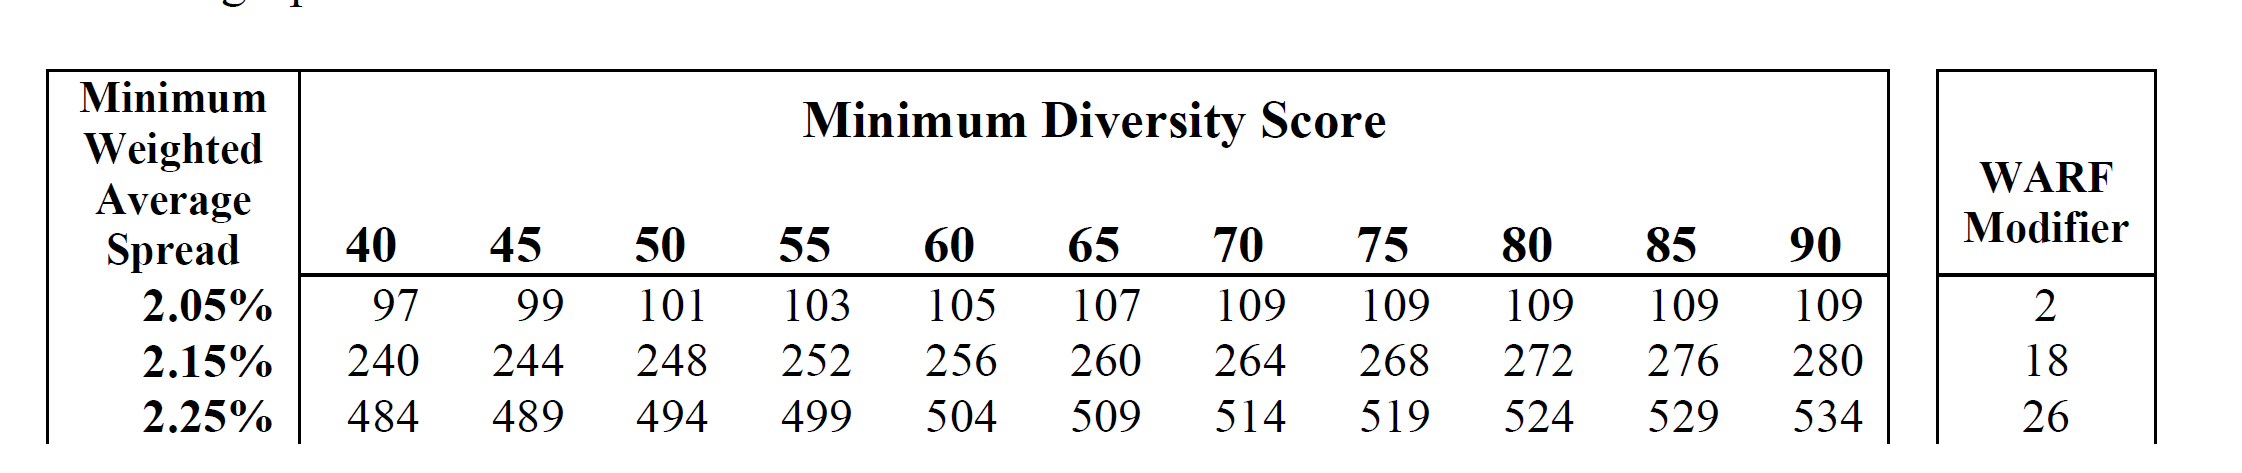
Issues to work through: 
1. Headers shifted down: This the opposite problem to ARAP since column titles were shifted into rows (instead of first row shifted into title). We create a new df removing these rows and add back in the column names 
2. There are lists of different lengths (5 elements on page, 6 elements page 2) for each page. We split out these lists into separate dfs, then concat them back to the originaol
3. Table spans two pages: concat individual pages together. 

In [73]:
# Sample of column headings showing up data
df_tables[1].iloc[0:2]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Minimum,NaN,NaN,NaN,Minimum Diversity Score,NaN,NaN,NaN,NaN
1,Weighted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# set column names for both pages then add them into table. 
mindiv1_cols = ['MWAS','40','45','50','MDS','80', '85', '90','WARF_Modifier']
mindiv2_cols = ['MWAS','40','45','50','MDS','85','Skip','90','WARF_Modifier']
df_mindiv1 = scrape.remrows_table_rename(df_tables[1], mindiv1_cols, 4)
df_mindiv2 = scrape.remrows_table_rename(df_tables[2][:-1], mindiv2_cols, 4)  # remove last record 
df_mindiv1.iloc[0:2]

,MWAS,40,45,50,MDS,80,85,90,WARF_Modifier
0,2.05%,97.0,99.0,101.0,103 105 107 109 109,109.0,109.0,109.0,2
1,2.15%,240.0,244.0,248.0,252 256 260 264 268,272.0,276.0,280.0,18


In [75]:
MDS1_cols = ['55','60','65','70','75']
MDS2_cols = ['55','60','65','70','75','80'] 
df_mindiv1 = scrape.split_lists_newdf(df_mindiv1, 'MDS', MDS1_cols, ' ')
df_mindiv2 = scrape.split_lists_newdf(df_mindiv2, 'MDS', MDS2_cols, ' ')
df_mindiv2[0:2]

,MWAS,40,45,50,MDS,85,Skip,90,WARF_Modifier,55,60,65,70,75,80
0,2.35%,675.0,681,687.0,693 699 705 711 717 723,729.0,NaN,735.0,31,693,699,705,711,717,723
1,2.45%,895.0,903,911.0,919 927 935 943 951 959,967.0,NaN,975.0,37,919,927,935,943,951,959


In [76]:
# Reorder concatenated pages 
mindiv_cols = ['MWAS','40','45','50','55','60','65','70','75','80','85','90','WARF_Modifier']
df_mindiv1 =df_mindiv1[mindiv_cols]
df_mindiv2 =df_mindiv2[mindiv_cols]

In [77]:
# combine pages and reset_index
df_mindiv = pd.concat([df_mindiv1,df_mindiv2],axis=0).reset_index(drop=True)  # 'drop=True' prevents new columns from being formed 
df_mindiv.shape
df_mindiv.head() 

(37, 13)

,MWAS,40,45,50,55,60,65,70,75,80,85,90,WARF_Modifier
0,2.05%,97.0,99,101.0,103,105,107,109,109,109,109.0,109.0,2
1,2.15%,240.0,244,248.0,252,256,260,264,268,272,276.0,280.0,18
2,2.25%,484.0,489,494.0,499,504,509,514,519,524,529.0,534.0,26
3,2.35%,675.0,681,687.0,693,699,705,711,717,723,729.0,735.0,31
4,2.45%,895.0,903,911.0,919,927,935,943,951,959,967.0,975.0,37


In [78]:
tbl_str = def_dict['Asset Quality Matrix']['def_values']
regex = r'\n\s+\n'
tbl_dict_proc = scrape.pop_tbldict(df_mindiv, tbl_str, regex)

In [79]:
def_dict['Asset Quality Matrix']['def_values'] = tbl_dict_proc

**Moody's Counterparty Criteria**

In [80]:
df_tables[3].iloc[0:2]

,Institution,Aggregate,Individual Percentage
0,(at or below),Percentage Limit,Limit
1,Aaa .............................................,20%,20%


In [81]:
# Moody's Counterparty Criteria" 
mdy_cols = ['MRSI','AggLimit','IndivLimit']
data_mc = scrape.remrows_table_rename(df_tables[3], mdy_cols, 1)
data_mc.iloc[0:2]

,MRSI,AggLimit,IndivLimit
0,Aaa .............................................,20%,20%
1,Aa1 .............................................,20%,10%


In [82]:
rmv_list = ['“', '”', '.']
data_mc['MRSI']= scrape.str_rmvlist_cleanup(data_mc['MRSI'],rmv_list)
data_mc

,MRSI,AggLimit,IndivLimit
0,Aaa,20%,20%
1,Aa1,20%,10%
2,Aa2,20%,10%
3,Aa3,15%,10%
4,A1 and P-1,10%,5%
5,A2 and P-1,5%,5%
6,A2 but not P-1 or less than A2,0%,0%


Populate ```def_dict```, but note there is also a closing paragraph. 

In [83]:
tbl_str = def_dict['Moody’s  Counterparty  Criteria']['def_values']
regex = r'\nMoody’s Credit Rating of Selling'
tbl_dict_proc = scrape.pop_tbldict(data_mc, tbl_str, regex)

In [84]:
# Grab closing paragraph to value dictionary and populate def_dict
regex_close = r'\nprovided that the Moody’s Counterparty'
tbl_dict_proc['closing_sec'] = scrape.pullsubstr_mid2end(regex_close, tbl_str)
def_dict['Moody’s  Counterparty  Criteria']['def_values'] = tbl_dict_proc

**Moody's Rating Factor** <br>
Column headings come though okay, but columns 1/2 and 3/4 are redundant and should be split and recombined into 2 columns (from 4). 

In [85]:
df_tables[4].iloc[0:2]
mrf_df = df_tables[4]

,Probability Rating,Moody’s Rating Factor,Probability Rating.1,Moody’s Rating Factor.1
0,“Aaa”,1,“Ba1”,940
1,“Aa1”,10,“Ba2”,"1,350"


In [86]:
mrf_df1 = mrf_df[['Probability Rating', 'Moody’s Rating Factor']]
mrf_df2 = mrf_df[['Probability Rating.1', 'Moody’s Rating Factor.1']]
mrf_df1.columns = mrf_df2.columns = ['Mdys_PD_Rating','Mdys_Rating_Factor']
mrf_df = pd.concat([mrf_df1, mrf_df2],axis=0).reset_index(drop=True) 

In [87]:
mrf_df.iloc[0:2]
mrf_df.shape

,Mdys_PD_Rating,Mdys_Rating_Factor
0,“Aaa”,1
1,“Aa1”,10


(20, 2)

In [88]:
tbl_str = def_dict['Moody’s Rating Factor']['def_values']
regex = r'\nMoody’s Default'
tbl_dict_proc = scrape.pop_tbldict(mrf_df, tbl_str, regex)

In [89]:
# Grab closing paragraph to value dictionary and populate def_dict
regex_close = r'\nFor  purposes  of  the  Maximum'
tbl_dict_proc['closing_sec'] = scrape.pullsubstr_mid2end(regex_close, tbl_str)

In [90]:
def_dict['Moody’s  Counterparty  Criteria']['def_values'] = tbl_dict_proc

**Required Coverage Ratio**
Table import was good: only need to change column names. 

In [91]:
df_reqcov = df_tables[6]
df_reqcov.columns = ['Class','OC_Ratio_Test','IC_Ratio_Test']
df_reqcov

,Class,OC_Ratio_Test,IC_Ratio_Test
0,A/B,125.0%,120.0%
1,C,117.6%,115.0%
2,D,109.6%,110.0%
3,E,104.7%,105.0%


In [92]:
tbl_str = def_dict['Required Coverage Ratio']['def_values']
regex = r'\nOvercollateralization  Interest Coverage'
tbl_dict_proc = scrape.pop_tbldict(df_reqcov, tbl_str, regex)

In [93]:
def_dict['Required Coverage Ratio']['def_values'] = tbl_dict_proc

**S&P CDO Model Inputs** 
Two tables part of bullet (ii)
1. S&P CDO Model Recovery Table** on Page 69 of doc (5th table): Also spans two pages and has embedded lists. Will be similar processing to *Minimum Diversity Score* table. <br> 
 - remove data rows with title info in them for both pages
 - rename columns for both
 - extract strings and combine back into dataframe for each page
 - Re-order columns 
 - combine back into one table. <br> 
2. S&P CDO Model Average Life Matrix 
3. Split out bullet (ii) into text then add 3 definitions into new dictionary ```bullet2_dict```. <br>
  - Table: S&P Model Recovery rate Matrix
  - Definition: S&P CDO Model Spread Matrix
  - Table: S&P CDO Model Average Life Matrix 
4. create new list ```bullet_level1``` and add append (i) and new ```bullet2_dict```. 

In [94]:
data_r1 = df_tables[7]
data_r1.head()

,Unnamed: 0,S&P CDO Model Recovery Rates (%)
0,NaN,Case Class A-1 Notes Class B Notes
1,NaN,NaN
2,1.0,48.50 58.40
3,2.0,48.25 58.10
4,3.0,48.00 57.80


In [95]:
# remove first wo rows and rename column titles 
col_names = ['Case','rec_list']
data_r1 = scrape.remrows_table_rename(df_tables[7], col_names, 2)
data_r2 = scrape.remrows_table_rename(df_tables[8], col_names, 2)
data_r1.iloc[0:2]
data_r1.shape

,Case,rec_list
0,1.0,48.50 58.40
1,2.0,48.25 58.10


(41, 2)

In [96]:
rec_cols = ['Class A Recovery','Class B Recovery']
data_r1 = scrape.split_lists_newdf(data_r1, 'rec_list', rec_cols, ' ')
data_r2 = scrape.split_lists_newdf(data_r2, 'rec_list', rec_cols, ' ')
data_r1.head() 

,Case,rec_list,Class A Recovery,Class B Recovery
0,1.0,48.50 58.40,48.50,58.40
1,2.0,48.25 58.10,48.25,58.10
2,3.0,48.00 57.80,48.00,57.80
3,4.0,47.75 57.50,47.75,57.50
4,5.0,47.50 57.20,47.50,57.20


In [97]:
# Re-order columns for each page and combine into one table. 
cols = ['Case', 'Class A Recovery','Class B Recovery']
data_r1 = data_r1[cols]
data_r2 = data_r2[cols]
data_r = pd.concat([data_r1, data_r2], axis=0).reset_index(drop=True)
data_r.head()
data_r.shape

,Case,Class A Recovery,Class B Recovery
0,1.0,48.50,58.40
1,2.0,48.25,58.10
2,3.0,48.00,57.80
3,4.0,47.75,57.50
4,5.0,47.50,57.20


(43, 3)

Populate def_dict

**S&P CDO Model Average Life Matrix Tables**<br>
Table spans three pages. For each dataframe, first row was moved to title. 

In [98]:
col_names = ['Case','SP_CDO_Model_Wghted_Avg_Life_Value']
df_avglife1 = scrape.shift_colnames_1strow(df_tables[9], col_names)  # shifts columns down into first row 
df_avglife2 = scrape.shift_colnames_1strow(df_tables[10], col_names)  # shifts columns down into first row 
df_avglife3 = scrape.shift_colnames_1strow(df_tables[11], col_names)  # shifts columns down into first row 

In [99]:
# combine 3 pages into one df. 
df_avglife = pd.concat([df_avglife1, df_avglife2, df_avglife3],axis=0).reset_index(drop=True)

In [100]:
# remove dots from "Case" columns
rmv_list = ['“', '”', '.']
df_avglife['Case'] = scrape.str_rmvlist_cleanup(df_avglife['Case'], rmv_list)

In [101]:
# sample beginning and end of S&P CDO Avg Life dataframe. 
df_avglife.iloc[0:2]
df_avglife.iloc[-2:]

,Case,SP_CDO_Model_Wghted_Avg_Life_Value
0,1,8.0
1,2,7.9


,Case,SP_CDO_Model_Wghted_Avg_Life_Value
79,80,0.1
80,81,0


**Split out bullet 2 and add tables**

In [102]:
bullet2_dict = {}
bullet2_str= def_dict['S&P CDO Model Inputs']['def_values']['bullet_level1'][1]  #store bullet (ii) contents into string 

In [103]:
regex = r'\n  -61- '
bullet2_dict = scrape.pop_tbldict(data_r, bullet2_str, regex)

In [104]:
# re-name table name to Model Recovery and  Spread & Average Life Matries
bullet2_dict['table_SP_CDO_Model_Recovery'] = bullet2_dict.pop('table')
bullet2_dict['SP_CDO_Model_Spread_Matrix'] = 'Any spread between 2.00% and 6.00% in 0.05% increments.'
bullet2_dict['table_SP_CDO_Model_AvgLife'] = df_avglife

In [105]:
# create new bullet_level list
bullet_level_list = []
   # add bullet(i) from S&P Model Inputs 
bullet_level_list.append(def_dict['S&P CDO Model Inputs']['def_values']['bullet_level1'][0])
bullet_level_list.append(bullet2_dict)

In [106]:
# update bullet level 1 with new list
def_dict['S&P CDO Model Inputs']['def_values']['bullet_level1'] = bullet_level_list

**Third Party Credit Exposure Limits** <br>
1. Shift headers into first row
2. clean up periods

In [107]:
col_names = ['SP_Rating_Sell_Inst','Agg_Perc_Limit','Indiv_Perc_Limit']
df_explim = scrape.shift_colnames_1strow(df_tables[12], col_names)
df_explim['SP_Rating_Sell_Inst'] = scrape.str_rmvlist_cleanup(df_explim['SP_Rating_Sell_Inst'],rmv_list)

In [108]:
tbl_str = def_dict['Third Party Credit Exposure Limits']['def_values']
regex = r'\nS&P’s credit rating of Selling Institution'
tbl_dict_proc = scrape.pop_tbldict(df_explim, tbl_str, regex)

In [109]:
def_dict['Third Party Credit Exposure Limits']['def_values'] = tbl_dict_proc

In [110]:
def_dict['Third Party Credit Exposure Limits']['def_values']

{'opening_sec': '  Limits that will be satisfied if the Third \nParty Credit Exposure with counterparties having the ratings below from S&P do not exceed the \npercentage of the Collateral Principal Amount specified below: \nAggregate  Individual \nPercentage  Percentage ',
 'table':                           SP_Rating_Sell_Inst Agg_Perc_Limit Indiv_Perc_Limit
 0                                         AAA            20%            20%.1
 1                                         AA+            10%              10%
 2                                          AA            10%              10%
 3                                         AA-            10%              10%
 4                                          A+             5%               5%
 5  A (with a short-term credit rating of A-1)             5%               5%
 6                                 A- or below             0%               0%}

### Export dictionary to excel
1. Convert ```def_dict``` into Dataframe 
2. Export as excel 

In [112]:
df_def_dict = pd.DataFrame.from_dict(def_dict, orient='index')
df_def_dict.to_excel('df_def_dict.xlsx')